In [1]:
import numpy as np

# length: Number of spins in the chain
length = 11
# ext_magn: External magnetic field strength in z-direction
ext_magn = 0.5
# coupling: Nearest-neighbor coupling strength for XX interactions
coupling = 1.0 
# relaxation_rate: Local amplitude damping (relaxation) rate
relaxation_rate = 0.1
# dephasing_rate: Local dephasing rate
dephasing_rate = 0.1
# time_step_size: Size of time steps for evolution
time_step_size = 0.02
# final_time: Total simulation time
final_time = 1
# evaluation_time: steps between exp. value calculation
evaluation_time = 1
# Initial local states to cunstruct product state
phys_tensor = np.array([1, 0])

print(f"# results: {(final_time/time_step_size)/evaluation_time + 1}")


# results: 51.0


In [2]:
from fractions import Fraction

from numpy import ndarray
from typing import Union
from pytreenet.special_ttn.binary import generate_binary_ttns
from pytreenet.ttns.ttndo import (SymmetricTTNDO,
                                  IntertwinedTTNDO,
                                  from_ttns_symmetric,
                                  from_mps_intertwined,
                                  from_ttns_fully_intertwined,
                                  from_ttns_physically_intertwined)
from pytreenet.operators.models import (ising_model,
                                        flipped_ising_model,
                                        local_magnetisation,)
from pytreenet.operators.sim_operators import single_site_operators
from pytreenet.operators.common_operators import pauli_matrices
from pytreenet.operators.tensorproduct import TensorProduct
from pytreenet.operators.lindbladian import generate_lindbladian
from pytreenet.ttno.ttno_class import TreeTensorNetworkOperator
from pytreenet.operators.hamiltonian import Hamiltonian
from pytreenet.operators.common_operators import (bosonic_operators,pauli_matrices)
from pytreenet.ttns.ttns import TreeTensorNetworkState
from pytreenet.time_evolution.bug import BUGConfig
from pytreenet.ttno.ttno_class import TTNO
from pytreenet.time_evolution.time_evolution import TimeEvoMode
from pytreenet.time_evolution.rbug import RBUG

def open_ising_model_ttno(length: int,
                          ttndo: Union[SymmetricTTNDO, IntertwinedTTNDO],
                          ext_magn: float,
                          coupling: float,
                          relaxation_rate: float,
                          dephasing_rate: float,
                          flipped: bool = False
                          ) -> tuple[TreeTensorNetworkOperator, Hamiltonian]:
    """
    Generates the Hamiltonian for the open Ising model.

    Additionally to the usual TFI model two jump operators act on every site
    separately. The first jump operator is relaxation and the second is 
    dephasing.

    Args:
        length (int): The length of the system.
        ttndo (SymmetricTTNDO): The TTNDO of the system.
        ext_magn (float): The external magnetic field.
        coupling (float): The coupling strength.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.
        flipped (bool): Whether to use the flipped Ising model.

    Returns:
        TreeTensorNetworkOperator: The TTNO.
    
    """
    node_identifiers = phys_node_identifiers(length)
    nn_pairs = [(node_identifiers[i], node_identifiers[i+1])
                for i in range(length-1)]
    if flipped:
        ham = flipped_ising_model(nn_pairs,
                                  ext_magn,
                                  factor=coupling)
    else:
        ham = ising_model(nn_pairs,
                          ext_magn,
                          factor=coupling)
    jump_ops, conversion_dict, coeff_dict = jump_operators(length,
                                                          relaxation_rate,
                                                          dephasing_rate)
    lindbladian = generate_lindbladian(ham,
                                        jump_ops,
                                        conversion_dict,
                                        coeff_dict)
    ttno = TreeTensorNetworkOperator.from_hamiltonian(lindbladian,
                                                      ttndo)
    return ttno, ham

def jump_operators(length: int,
                   relaxation_rate: float,
                   dephasing_rate:float
                   ) -> tuple[list[tuple[Fraction,str,TensorProduct]], dict[str,ndarray], dict[str,complex]]:
    """
    Generates the jump operators for the open Ising model.

    Args:
        length (int): The length of the system.
        relaxation_rate (float): The relaxation rate.
        dephasing_rate (float): The dephasing rate.

    Returns:
        list[tuple[Fraction,str,TensorProduct]]: The jump operator terms.
        dict[str,ndarray]: The jump operator conversion dictionary.
        dict[str,float]: The jump operator coefficient mapping
    
    """
    node_identifiers = phys_node_identifiers(length)
    # Create relaxation jump operators
    rel_fac_name = "relaxation_rate"
    factor = (Fraction(1), rel_fac_name)
    relax_name = "sigma_-"
    relaxation_ops = single_site_operators(relax_name,
                                           node_identifiers,
                                           factor)
    # Create dephasing jump operators
    deph_fac_name = "dephasing_rate"
    factor = (Fraction(1), deph_fac_name)
    deph_name = "Z" 
    dephasing_ops = single_site_operators(deph_name,
                                          node_identifiers,
                                          factor)
    # Combine the jump operators
    jump_ops = list(relaxation_ops.values())
    jump_ops.extend(list(dephasing_ops.values()))
    # Create the jump operator matrix mapping
    conversion_dict = {relax_name: bosonic_operators()[1],
                       deph_name: pauli_matrices()[2]}
    # Create the jump operator coefficient mapping
    coeff_dict = {rel_fac_name: complex(relaxation_rate),
                  deph_fac_name: complex(dephasing_rate)}
    return jump_ops, conversion_dict, coeff_dict

def phys_node_identifiers(length: int) -> list[str]:
    """
    Generates the node identifiers for the physical nodes.

    Args:
        length (int): The length of the system.
    
    Returns:
        list[str]: The node identifiers.
    """
    return [f"qubit{i}" for i in range(length)]

def open_ising_operators(length: int,
                         ttns: TreeTensorNetworkState,
                         ising_ham: Hamiltonian
                         ) -> dict:
    """
    Generates the operators to be evaluated for the open Ising model.
    
    Args:
        length (int): The length of the system.
        ttns (TreeTensorNetworkState): The TTN state of the system.
        ising_ham (Hamiltonian): The Ising Hamiltonian.
    
    Returns:
        dict: The operators.

    """
    node_identifiers = phys_node_identifiers(length)
    ops = {key: tup[2]
           for key, tup in local_magnetisation(node_identifiers).items()}
    ttno = TreeTensorNetworkOperator.from_hamiltonian(ising_ham,
                                                      ttns)
    ops["energy"] = ttno

    Identity = TTNO.Identity(ttns)
    ops["Identity"] = Identity
    return ops

ImportError: cannot import name 'IntertwinedTTNDO' from 'pytreenet.ttns.ttndo' (c:\Users\edpou\Desktop\PTN\PyTreeNet\pytreenet\ttns\ttndo.py)

In [ ]:
import numpy as np

# length: Number of spins in the chain
length = 13
# ext_magn: External magnetic field strength in z-direction
ext_magn = 0.5
# coupling: Nearest-neighbor coupling strength for XX interactions
coupling = 1.0 
# relaxation_rate: Local amplitude damping (relaxation) rate
relaxation_rate = 0.1
# dephasing_rate: Local dephasing rate
dephasing_rate = 0.1
# time_step_size: Size of time steps for evolution
time_step_size = 0.02
# final_time: Total simulation time
final_time = 1
# evaluation_time: steps between exp. value calculation
evaluation_time = 1
# Initial local states to cunstruct product state
phys_tensor = np.array([1, 0])


print(f"# results: {(final_time/time_step_size)/evaluation_time + 1}")


# results: 51.0


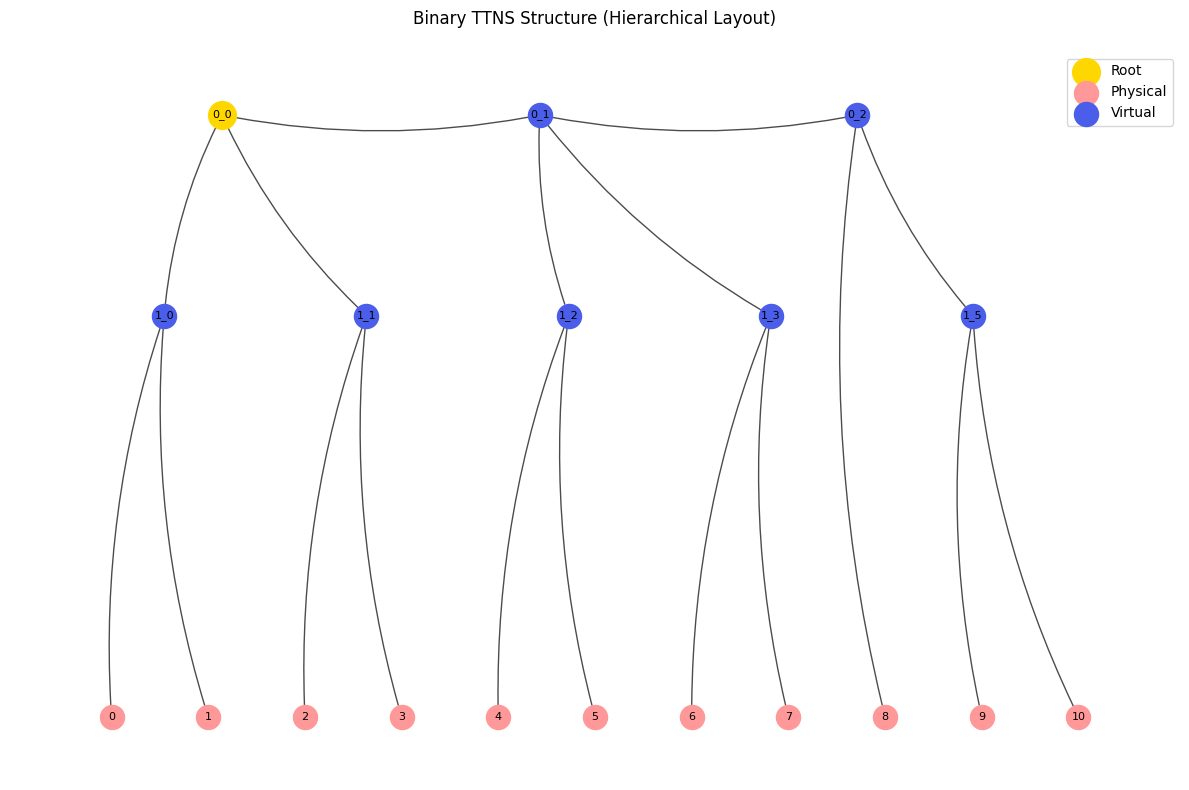

In [3]:
depth = 2
initial_bond_dim = 4
max_effective_ham_dim = 1200
total_tol = 1e-8

ttns = generate_binary_ttns(num_phys=length,
                            bond_dim=initial_bond_dim,
                            phys_tensor=phys_tensor,
                            depth=depth)

from pytreenet.special_ttn.binary_visualize import (visualize_binary_ttns,
                    visualize_symmetric_ttndo,
                    visualize_binary_ttndo)
visualize_binary_ttns(ttns,
                        layout_type="hierarchical",
simplified_labels=True)

In [ ]:
depth = 0
initial_bond_dim = 4
max_effective_ham_dim = 1200
total_tol = 1e-8

ttns = generate_binary_ttns(num_phys=length,
                            bond_dim=initial_bond_dim,
                            phys_tensor=phys_tensor,
                            depth=depth)
ttndo = from_mps_intertwined(ttns, initial_bond_dim, phys_tensor) 
lindbladian_ttno, ising_ham = open_ising_model_ttno(length,
                                                    ttndo,
                                                    ext_magn,
                                                    coupling,
                                                    relaxation_rate,
                                                    dephasing_rate)

# Observables
operators = open_ising_operators(length,
                                    ttns,
                                    ising_ham)

# BUG simulation
config = BUGConfig(max_bond_dim= np.inf,
                    max_effective_ham_dim= max_effective_ham_dim,
                    total_tol= total_tol,
                    rel_tol= 0,
                    renorm = True,
                    sum_trunc= True,
                    sum_renorm = False,
                    record_bond_dim= True,
                    time_evo_mode = TimeEvoMode.JAX_RK4)
from pytreenet.time_evolution.sbug import SBUG
from pytreenet.time_evolution.bug import BUG
from pytreenet.time_evolution.rbug import RBUG
from pytreenet.time_evolution.secondorder_sbug import SSBUG
bug = SSBUG(initial_state = ttndo, hamiltonian = lindbladian_ttno, time_step_size = time_step_size, final_time = final_time, operators = operators, config=config)


NameError: name 'from_mps_intertwined' is not defined

In [ ]:
import cProfile
import pstats
import numpy as np

profiler = cProfile.Profile()
profiler.enable()

bug.run_one_time_step()

profiler.disable()

# --- Print profiling results ---
# Use pstats to sort and print the results
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()

In [ ]:
# Stiffness Variation Test: Constant Steps, Varying Stiffness
# This test keeps the number of time steps constant and varies the stiffness ratio
# to understand how each solver handles increasingly stiff systems

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import time
import jax.numpy as jnp

from pytreenet.time_evolution.time_evo_util.jax_rk4 import rk4_evolve, dirk_evolve
from pytreenet.time_evolution.time_evo_util.jax_rk8 import rk8_evolve
from pytreenet.time_evolution.time_evo_util.jax_rk45 import rk45_evolve
from pytreenet.time_evolution.time_evolution import TimeEvoMode, scipy_evolve

def create_stiff_hamiltonian_v2(dimension=10, stiffness_ratio=1000.0):
    """
    Create a stiff Hamiltonian matrix with widely separated eigenvalues.
    Enhanced version with better conditioning for extreme stiffness ratios.
    """
    # Use logarithmically spaced eigenvalues from 1e-3 to stiffness_ratio * 1e-3
    eigenvalues = np.logspace(-3, np.log10(stiffness_ratio * 1e-3), dimension)
    
    # Create a random unitary matrix for the basis change
    np.random.seed(42)  # Fixed seed for reproducibility across stiffness tests
    random_matrix = np.random.randn(dimension, dimension) + 1j * np.random.randn(dimension, dimension)
    q, _ = np.linalg.qr(random_matrix)  # Orthogonalize to get a unitary matrix
    
    # Create the Hamiltonian H = Q D Q†
    H = q @ np.diag(eigenvalues) @ q.conj().T
    
    # Apply -i factor for Schrödinger equation evolution
    return -1j * H

def exact_solution_v2(psi_initial, hamiltonian, t):
    """Calculate exact solution using matrix exponentiation."""
    # Since H already includes -i factor, we can directly use expm(H * t)
    U = scipy.linalg.expm(hamiltonian * t)
    return U @ psi_initial

def scipy_rk45_wrapper_v2(dimension, psi, hamiltonian, time_difference, max_dt):
    """Wrapper for scipy RK45 solver to match JAX solver interface."""
    mode = TimeEvoMode.SCIPY_RK45._replace(num_step=int(np.ceil(time_difference / max_dt)))
    return scipy_evolve(psi, hamiltonian, time_difference, max_dt, mode)

def scipy_dop853_wrapper_v2(dimension, psi, hamiltonian, time_difference, max_dt):
    """Wrapper for scipy DOP853 solver to match JAX solver interface."""
    mode = TimeEvoMode.SCIPY_DOP853._replace(num_step=int(np.ceil(time_difference / max_dt)))    
    return scipy_evolve(psi, hamiltonian, time_difference, max_dt, mode)

# Test parameters
dim = 1600  # Smaller dimension for faster testing with high stiffness
fixed_steps = 50  # Fixed number of time steps
time_diff = 0.5  # Total evolution time
max_dt = time_diff / fixed_steps  # Fixed time step size

# Range of stiffness ratios to test
stiffness_ratios = [1e1, 1e2, 1e3, 1e4, 1e5]  # From mildly stiff to extremely stiff

# Define all methods to test
methods_v2 = {
    'JAX_RK4': rk4_evolve,
    'JAX_RK8': rk8_evolve,
    'JAX_RK45': rk45_evolve,
    'JAX_DIRK': dirk_evolve,
    'SCIPY_RK45': scipy_rk45_wrapper_v2,
    'SCIPY_DOP853': scipy_dop853_wrapper_v2
}

# Initialize results storage
stiffness_results = {}
for method_name in methods_v2:
    stiffness_results[method_name] = {'errors': [], 'times': [], 'failures': []}

print(f"Stiffness Variation Test")
print(f"Dimension: {dim}, Fixed steps: {fixed_steps}, Time step: {max_dt:.6f}")
print(f"Total evolution time: {time_diff}")
print("\nTesting how each solver handles increasing stiffness...")
print()

# Header for results table
header = f"{'Stiffness':>10} | {'Eigenval Range':>20}"
for method_name in methods_v2:
    header += f" | {method_name+' Error':>12} | {method_name+' Time':>10}"
print(header)
print("-" * (len(header) + 20))

# Run tests for each stiffness ratio
for stiffness_ratio in stiffness_ratios:
    # Create Hamiltonian for this stiffness
    H_stiff = create_stiff_hamiltonian_v2(dim, stiffness_ratio)
    
    # Create initial state (same for all stiffness levels for comparison)
    np.random.seed(123)  # Different seed for initial state
    psi_initial = np.random.randn(dim) + 1j * np.random.randn(dim)
    psi_initial = psi_initial / np.linalg.norm(psi_initial)
    
    # Calculate exact solution
    psi_exact = exact_solution_v2(psi_initial, H_stiff, time_diff)
    
    # Get eigenvalue range for display
    eigenvals = np.linalg.eigvals(H_stiff / (-1j))
    eig_min, eig_max = eigenvals.min().real, eigenvals.max().real
    
    row_data = [f"{stiffness_ratio:.0e}", f"{eig_min:.1e} to {eig_max:.1e}"]
    
    # Test each method
    for method_name, method_func in methods_v2.items():
        try:
            start_time = time.time()
            psi_result = method_func(dim, psi_initial, H_stiff, time_diff, max_dt)
            method_time = time.time() - start_time
            method_error = np.linalg.norm(psi_result - psi_exact)
            
            # Check for numerical issues
            if np.isnan(method_error) or np.isinf(method_error) or method_error > 1e10:
                raise ValueError(f"Numerical instability detected: error = {method_error}")
            
            stiffness_results[method_name]['errors'].append(method_error)
            stiffness_results[method_name]['times'].append(method_time)
            stiffness_results[method_name]['failures'].append(False)
            row_data.extend([f"{method_error:12.2e}", f"{method_time:10.6f}"])
            
        except Exception as e:
            stiffness_results[method_name]['errors'].append(np.nan)
            stiffness_results[method_name]['times'].append(np.nan)
            stiffness_results[method_name]['failures'].append(True)
            row_data.extend([f"{'FAILED':>12}", f"{'N/A':>10}"])
            print(f"\n    {method_name} failed at stiffness {stiffness_ratio:.0e}: {str(e)[:50]}...")
    
    print(" | ".join(row_data))

print("\n" + "="*80)

In [ ]:
# Create comprehensive visualization for stiffness test
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Define colors and markers for each method (consistent with previous test)
colors_v2 = {
    'JAX_RK4': 'blue', 
    'JAX_RK8': 'red', 
    'JAX_RK45': 'cyan',
    'JAX_DIRK': 'purple',
    'SCIPY_RK45': 'green',
    'SCIPY_DOP853': 'orange'
}
markers_v2 = {
    'JAX_RK4': 'o', 
    'JAX_RK8': 'D', 
    'JAX_RK45': '*',
    'JAX_DIRK': 'v',
    'SCIPY_RK45': 's',
    'SCIPY_DOP853': 'h'
}

# Plot 1: Error vs Stiffness Ratio
for method_name in methods_v2:
    errors = stiffness_results[method_name]['errors']
    valid_indices = [i for i, err in enumerate(errors) if not np.isnan(err)]
    if valid_indices:
        valid_stiffness = [stiffness_ratios[i] for i in valid_indices]
        valid_errors = [errors[i] for i in valid_indices]
        ax1.loglog(valid_stiffness, valid_errors, 
                  marker=markers_v2[method_name], color=colors_v2[method_name], 
                  label=method_name, markersize=8, linewidth=2, linestyle='-')

ax1.set_xlabel('Stiffness Ratio')
ax1.set_ylabel('Error (L2 norm)')
ax1.set_title('Error vs Stiffness Ratio (Fixed Steps = 50)')
ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.legend()

# Plot 2: Computation Time vs Stiffness Ratio
for method_name in methods_v2:
    times = stiffness_results[method_name]['times']
    valid_indices = [i for i, t in enumerate(times) if not np.isnan(t)]
    if valid_indices:
        valid_stiffness = [stiffness_ratios[i] for i in valid_indices]
        valid_times = [times[i] for i in valid_indices]
        ax2.semilogx(valid_stiffness, valid_times, 
                    marker=markers_v2[method_name], color=colors_v2[method_name], 
                    label=method_name, markersize=8, linewidth=2, linestyle='-')

ax2.set_xlabel('Stiffness Ratio')
ax2.set_ylabel('Computation Time (s)')
ax2.set_title('Computation Time vs Stiffness Ratio')
ax2.grid(True, which='both', linestyle='--', alpha=0.6)
ax2.legend()

# Plot 3: Error vs Computation Time (for different stiffness levels)
for method_name in methods_v2:
    times = stiffness_results[method_name]['times']
    errors = stiffness_results[method_name]['errors']
    valid_indices = [i for i, (t, err) in enumerate(zip(times, errors)) 
                    if not np.isnan(t) and not np.isnan(err)]
    if valid_indices:
        valid_times = [times[i] for i in valid_indices]
        valid_errors = [errors[i] for i in valid_indices]
        ax3.loglog(valid_times, valid_errors, 
                  marker=markers_v2[method_name], color=colors_v2[method_name], 
                  label=method_name, markersize=8, linewidth=2, linestyle='-')
        
        # Add stiffness ratio annotations
        for i, idx in enumerate(valid_indices):
            ax3.annotate(f"{stiffness_ratios[idx]:.0e}", 
                        (valid_times[i], valid_errors[i]), 
                        textcoords="offset points", xytext=(5,5), 
                        ha='left', fontsize=7, 
                        bbox=dict(boxstyle="round,pad=0.2", fc=colors_v2[method_name], alpha=0.3))

ax3.set_xlabel('Computation Time (s)')
ax3.set_ylabel('Error (L2 norm)')
ax3.set_title('Error vs Computation Time (Stiffness Annotated)')
ax3.grid(True, which='both', linestyle='--', alpha=0.6)
ax3.legend()

# Plot 4: Stability Map (Success/Failure for each method vs stiffness)
stiffness_log = np.log10(stiffness_ratios)
method_names = list(methods_v2.keys())
y_positions = np.arange(len(method_names))

for i, method_name in enumerate(method_names):
    failures = stiffness_results[method_name]['failures']
    for j, failed in enumerate(failures):
        color = 'red' if failed else 'green'
        marker = 'X' if failed else 'o'
        ax4.scatter(stiffness_log[j], i, c=color, marker=marker, s=100, alpha=0.7)

ax4.set_xlabel('Log10(Stiffness Ratio)')
ax4.set_ylabel('Solver Method')
ax4.set_title('Solver Stability Map\n(Green = Success, Red = Failure)')
ax4.set_yticks(y_positions)
ax4.set_yticklabels(method_names)
ax4.grid(True, alpha=0.3)

# Add legend for stability map
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Success'),
                  Line2D([0], [0], marker='X', color='w', markerfacecolor='red', markersize=10, label='Failure')]
ax4.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

# Detailed Analysis
print("\nDETAILED STIFFNESS ANALYSIS")
print("="*50)

# Find the stiffness threshold for each method
print("\nStiffness Tolerance Analysis:")
for method_name in methods_v2:
    failures = stiffness_results[method_name]['failures']
    if any(failures):
        first_failure_idx = failures.index(True)
        max_stiffness = stiffness_ratios[first_failure_idx - 1] if first_failure_idx > 0 else "None"
        print(f"{method_name:12s}: Fails at stiffness {stiffness_ratios[first_failure_idx]:.0e}, max stable: {max_stiffness}")
    else:
        print(f"{method_name:12s}: Handles all tested stiffness levels (up to {stiffness_ratios[-1]:.0e})")

# Best performance at each stiffness level
print("\nBest Performer at Each Stiffness Level:")
print(f"{'Stiffness':>10} | {'Best Method':>12} | {'Best Error':>12} | {'Fastest Method':>12} | {'Best Time':>10}")
print("-" * 70)

for i, stiffness in enumerate(stiffness_ratios):
    # Find best accuracy
    valid_errors = {}
    valid_times = {}
    
    for method_name in methods_v2:
        if not stiffness_results[method_name]['failures'][i]:
            valid_errors[method_name] = stiffness_results[method_name]['errors'][i]
            valid_times[method_name] = stiffness_results[method_name]['times'][i]
    
    if valid_errors:
        best_accuracy_method = min(valid_errors, key=valid_errors.get)
        best_accuracy_error = valid_errors[best_accuracy_method]
        
        fastest_method = min(valid_times, key=valid_times.get)
        fastest_time = valid_times[fastest_method]
        
        print(f"{stiffness:10.0e} | {best_accuracy_method:>12} | {best_accuracy_error:12.2e} | {fastest_method:>12} | {fastest_time:10.6f}")
    else:
        print(f"{stiffness:10.0e} | {'ALL FAILED':>12} | {'N/A':>12} | {'ALL FAILED':>12} | {'N/A':>10}")

# Overall performance summary
print("\nOVERALL PERFORMANCE SUMMARY:")
print("-" * 40)

for method_name in methods_v2:
    errors = [e for e in stiffness_results[method_name]['errors'] if not np.isnan(e)]
    times = [t for t in stiffness_results[method_name]['times'] if not np.isnan(t)]
    failures = sum(stiffness_results[method_name]['failures'])
    
    if errors:
        avg_error = np.mean(errors)
        min_error = np.min(errors)
        avg_time = np.mean(times)
        success_rate = (len(stiffness_ratios) - failures) / len(stiffness_ratios) * 100
        
        print(f"{method_name:12s}: Success rate: {success_rate:5.1f}%, Avg error: {avg_error:.2e}, "
              f"Min error: {min_error:.2e}, Avg time: {avg_time:.4f}s")
    else:
        print(f"{method_name:12s}: Failed on all test cases")

print("\nKey Insights:")
print("- Higher-order methods (RK8, RK45, DOP853) should maintain accuracy better at high stiffness")
print("- DIRK methods should be more stable for stiff systems")
print("- Implicit methods generally handle stiffness better than explicit methods")
print("- JAX implementations may have different numerical properties than SciPy")

In [ ]:
# Dimension Scaling Test: Constant Steps and Stiffness, Varying Dimension
# This test keeps the number of time steps and stiffness ratio constant
# and varies the system dimension to understand computational scaling

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import time
import jax.numpy as jnp

from pytreenet.time_evolution.time_evo_util.jax_rk4 import rk4_evolve, dirk_evolve
from pytreenet.time_evolution.time_evo_util.jax_rk8 import rk8_evolve
from pytreenet.time_evolution.time_evo_util.jax_rk45 import rk45_evolve
from pytreenet.time_evolution.time_evolution import TimeEvoMode, scipy_evolve

def create_stiff_hamiltonian_v3(dimension=10, stiffness_ratio=1000.0):
    """
    Create a stiff Hamiltonian matrix with widely separated eigenvalues.
    Optimized version for dimension scaling tests.
    """
    # Use logarithmically spaced eigenvalues from 1e-3 to stiffness_ratio * 1e-3
    eigenvalues = np.logspace(-3, np.log10(stiffness_ratio * 1e-3), dimension)
    
    # Create a random unitary matrix for the basis change
    # Use fixed seed but vary with dimension for reproducibility
    np.random.seed(42 + dimension % 100)  
    random_matrix = np.random.randn(dimension, dimension) + 1j * np.random.randn(dimension, dimension)
    q, _ = np.linalg.qr(random_matrix)  # Orthogonalize to get a unitary matrix
    
    # Create the Hamiltonian H = Q D Q†
    H = random_matrix @ np.diag(eigenvalues) @ q.conj().T
    
    # Apply -i factor for Schrödinger equation evolution
    return -1j * H

def exact_solution_v3(psi_initial, hamiltonian, t):
    """Calculate exact solution using matrix exponentiation."""
    # Since H already includes -i factor, we can directly use expm(H * t)
    U = scipy.linalg.expm(hamiltonian * t)
    return U @ psi_initial

def scipy_rk45_wrapper_v3(dimension, psi, hamiltonian, time_difference, max_dt):
    """Wrapper for scipy RK45 solver to match JAX solver interface."""
    mode = TimeEvoMode.SCIPY_RK45._replace(num_step=int(np.ceil(time_difference / max_dt)))
    return scipy_evolve(psi, hamiltonian, time_difference, max_dt, mode)

def scipy_dop853_wrapper_v3(dimension, psi, hamiltonian, time_difference, max_dt):
    """Wrapper for scipy DOP853 solver to match JAX solver interface."""
    mode = TimeEvoMode.SCIPY_DOP853._replace(num_step=int(np.ceil(time_difference / max_dt)))    
    return scipy_evolve(psi, hamiltonian, time_difference, max_dt, mode)

# Test parameters
fixed_stiffness = 1e3  # Fixed stiffness ratio
fixed_steps = 40  # Fixed number of time steps
time_diff = 0.5  # Total evolution time
max_dt = time_diff / fixed_steps  # Fixed time step size

# Range of dimensions to test (moderate sizes to avoid memory issues)
dimensions = [800, 1200, 1600, 2000]  # From small to moderately large systems

# Define all methods to test
methods_v3 = {
    'JAX_RK4': rk4_evolve,
    'JAX_RK8': rk8_evolve,
    'JAX_RK45': rk45_evolve,
    'JAX_DIRK': dirk_evolve,
    'SCIPY_RK45': scipy_rk45_wrapper_v3,
    'SCIPY_DOP853': scipy_dop853_wrapper_v3
}

# Initialize results storage
dimension_results = {}
for method_name in methods_v3:
    dimension_results[method_name] = {'errors': [], 'times': [], 'failures': [], 'memory_usage': []}

print(f"Dimension Scaling Test")
print(f"Fixed stiffness: {fixed_stiffness:.0e}, Fixed steps: {fixed_steps}, Time step: {max_dt:.6f}")
print(f"Total evolution time: {time_diff}")
print("\nTesting how each solver scales with system dimension...")
print()

# Header for results table
header = f"{'Dimension':>9} | {'Matrix Size':>11}"
for method_name in methods_v3:
    header += f" | {method_name+' Error':>12} | {method_name+' Time':>10}"
print(header)
print("-" * (len(header) + 20))

# Run tests for each dimension
for dim in dimensions:
    print(f"\nTesting dimension {dim}...")
    
    # Create Hamiltonian for this dimension
    H_stiff = create_stiff_hamiltonian_v3(dim, fixed_stiffness)
    
    # Create initial state
    np.random.seed(456)  # Fixed seed for initial state across all dimensions
    psi_initial = np.random.randn(dim) + 1j * np.random.randn(dim)
    psi_initial = psi_initial / np.linalg.norm(psi_initial)
    
    # Calculate exact solution
    try:
        psi_exact = exact_solution_v3(psi_initial, H_stiff, time_diff)
    except Exception as e:
        print(f"    Exact solution failed for dimension {dim}: {e}")
        # Fill with NaN for all methods at this dimension
        for method_name in methods_v3:
            dimension_results[method_name]['errors'].append(np.nan)
            dimension_results[method_name]['times'].append(np.nan)
            dimension_results[method_name]['failures'].append(True)
            dimension_results[method_name]['memory_usage'].append(np.nan)
        continue
    
    matrix_size = f"{dim}x{dim}"
    row_data = [f"{dim:9d}", f"{matrix_size:>11}"]
    
    # Test each method
    for method_name, method_func in methods_v3.items():
        try:
            start_time = time.time()
            psi_result = method_func(dim, psi_initial, H_stiff, time_diff, max_dt)
            method_time = time.time() - start_time
            method_error = np.linalg.norm(psi_result - psi_exact)
            
            # Estimate memory usage (rough approximation)
            # Complex matrix uses 16 bytes per element
            memory_mb = (dim * dim * 16) / (1024 * 1024)
            
            # Check for numerical issues
            if np.isnan(method_error) or np.isinf(method_error) or method_error > 1e10:
                raise ValueError(f"Numerical instability detected: error = {method_error}")
            
            dimension_results[method_name]['errors'].append(method_error)
            dimension_results[method_name]['times'].append(method_time)
            dimension_results[method_name]['failures'].append(False)
            dimension_results[method_name]['memory_usage'].append(memory_mb)
            row_data.extend([f"{method_error:12.2e}", f"{method_time:10.6f}"])
            
        except Exception as e:
            dimension_results[method_name]['errors'].append(np.nan)
            dimension_results[method_name]['times'].append(np.nan)
            dimension_results[method_name]['failures'].append(True)
            dimension_results[method_name]['memory_usage'].append(np.nan)
            row_data.extend([f"{'FAILED':>12}", f"{'N/A':>10}"])
            print(f"    {method_name} failed at dimension {dim}: {str(e)[:50]}...")
    
    print(" | ".join(row_data))

print("\n" + "="*80)

In [ ]:
# Create comprehensive visualization for dimension scaling test
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Define colors and markers for each method (consistent with previous tests)
colors_v3 = {
    'JAX_RK4': 'blue', 
    'JAX_RK8': 'red', 
    'JAX_RK45': 'cyan',
    'JAX_DIRK': 'purple',
    'SCIPY_RK45': 'green',
    'SCIPY_DOP853': 'orange'
}
markers_v3 = {
    'JAX_RK4': 'o', 
    'JAX_RK8': 'D', 
    'JAX_RK45': '*',
    'JAX_DIRK': 'v',
    'SCIPY_RK45': 's',
    'SCIPY_DOP853': 'h'
}

# Plot 1: Error vs Dimension
for method_name in methods_v3:
    errors = dimension_results[method_name]['errors']
    valid_indices = [i for i, err in enumerate(errors) if not np.isnan(err)]
    if valid_indices:
        valid_dimensions = [dimensions[i] for i in valid_indices]
        valid_errors = [errors[i] for i in valid_indices]
        ax1.loglog(valid_dimensions, valid_errors, 
                  marker=markers_v3[method_name], color=colors_v3[method_name], 
                  label=method_name, markersize=8, linewidth=2, linestyle='-')

ax1.set_xlabel('System Dimension')
ax1.set_ylabel('Error (L2 norm)')
ax1.set_title('Error vs System Dimension')
ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.legend()

# Plot 2: Computation Time vs Dimension
for method_name in methods_v3:
    times = dimension_results[method_name]['times']
    valid_indices = [i for i, t in enumerate(times) if not np.isnan(t)]
    if valid_indices:
        valid_dimensions = [dimensions[i] for i in valid_indices]
        valid_times = [times[i] for i in valid_indices]
        ax2.loglog(valid_dimensions, valid_times, 
                  marker=markers_v3[method_name], color=colors_v3[method_name], 
                  label=method_name, markersize=8, linewidth=2, linestyle='-')
        
        # Add scaling reference lines
        if len(valid_dimensions) >= 2:
            # Fit a power law: time ~ dimension^alpha
            log_dims = np.log(valid_dimensions)
            log_times = np.log(valid_times)
            if len(log_dims) > 1:
                slope, intercept = np.polyfit(log_dims, log_times, 1)
                scaling_line = np.exp(intercept) * np.array(valid_dimensions)**slope
                ax2.plot(valid_dimensions, scaling_line, '--', 
                        color=colors_v3[method_name], alpha=0.5, linewidth=1)
                ax2.text(valid_dimensions[-1], valid_times[-1], f'~N^{slope:.1f}', 
                        color=colors_v3[method_name], fontsize=8)

ax2.set_xlabel('System Dimension')
ax2.set_ylabel('Computation Time (s)')
ax2.set_title('Computation Time vs System Dimension')
ax2.grid(True, which='both', linestyle='--', alpha=0.6)
ax2.legend()

# Plot 3: Error vs Computation Time (dimension annotated)
for method_name in methods_v3:
    times = dimension_results[method_name]['times']
    errors = dimension_results[method_name]['errors']
    valid_indices = [i for i, (t, err) in enumerate(zip(times, errors)) 
                    if not np.isnan(t) and not np.isnan(err)]
    if valid_indices:
        valid_times = [times[i] for i in valid_indices]
        valid_errors = [errors[i] for i in valid_indices]
        ax3.loglog(valid_times, valid_errors, 
                  marker=markers_v3[method_name], color=colors_v3[method_name], 
                  label=method_name, markersize=8, linewidth=2, linestyle='-')
        
        # Add dimension annotations
        for i, idx in enumerate(valid_indices):
            ax3.annotate(f"{dimensions[idx]}", 
                        (valid_times[i], valid_errors[i]), 
                        textcoords="offset points", xytext=(5,5), 
                        ha='left', fontsize=7, 
                        bbox=dict(boxstyle="round,pad=0.2", fc=colors_v3[method_name], alpha=0.3))

ax3.set_xlabel('Computation Time (s)')
ax3.set_ylabel('Error (L2 norm)')
ax3.set_title('Error vs Computation Time (Dimension Annotated)')
ax3.grid(True, which='both', linestyle='--', alpha=0.6)
ax3.legend()

# Plot 4: Memory Usage vs Dimension
theoretical_memory = [(d**2 * 16) / (1024**2) for d in dimensions]  # Theoretical memory in MB
ax4.loglog(dimensions, theoretical_memory, 'k--', linewidth=2, label='Theoretical (N²)', alpha=0.7)

for method_name in methods_v3:
    memory_usage = dimension_results[method_name]['memory_usage']
    valid_indices = [i for i, mem in enumerate(memory_usage) if not np.isnan(mem)]
    if valid_indices:
        valid_dimensions = [dimensions[i] for i in valid_indices]
        valid_memory = [memory_usage[i] for i in valid_indices]
        ax4.loglog(valid_dimensions, valid_memory, 
                  marker=markers_v3[method_name], color=colors_v3[method_name], 
                  label=method_name, markersize=8, linewidth=2, linestyle='-')

ax4.set_xlabel('System Dimension')
ax4.set_ylabel('Memory Usage (MB)')
ax4.set_title('Memory Usage vs System Dimension')
ax4.grid(True, which='both', linestyle='--', alpha=0.6)
ax4.legend()

plt.tight_layout()
plt.show()

# Detailed Analysis
print("\nDETAILED DIMENSION SCALING ANALYSIS")
print("="*55)

# Computational scaling analysis
print("\nComputational Scaling Analysis:")
for method_name in methods_v3:
    times = dimension_results[method_name]['times']
    valid_indices = [i for i, t in enumerate(times) if not np.isnan(t)]
    if len(valid_indices) >= 2:
        valid_dimensions = [dimensions[i] for i in valid_indices]
        valid_times = [times[i] for i in valid_indices]
        
        # Fit scaling law: time ~ dimension^alpha
        log_dims = np.log(valid_dimensions)
        log_times = np.log(valid_times)
        slope, intercept = np.polyfit(log_dims, log_times, 1)
        r_squared = np.corrcoef(log_dims, log_times)[0, 1]**2
        
        print(f"{method_name:12s}: Scaling ~ N^{slope:.2f} (R² = {r_squared:.3f})")
        
        # Theoretical expectation for matrix operations is N³
        if slope > 2.5:
            scaling_type = "Matrix-dominated (expected ~N³)"
        elif slope > 1.5:
            scaling_type = "Intermediate scaling"
        else:
            scaling_type = "Linear/sub-quadratic scaling"
        print(f"{'':14s}  {scaling_type}")
    else:
        print(f"{method_name:12s}: Insufficient data for scaling analysis")

# Performance at each dimension
print("\nBest Performer at Each Dimension:")
print(f"{'Dimension':>9} | {'Best Method':>12} | {'Best Error':>12} | {'Fastest Method':>12} | {'Best Time':>10}")
print("-" * 75)

for i, dim in enumerate(dimensions):
    # Find best accuracy and fastest method
    valid_errors = {}
    valid_times = {}
    
    for method_name in methods_v3:
        if not dimension_results[method_name]['failures'][i]:
            valid_errors[method_name] = dimension_results[method_name]['errors'][i]
            valid_times[method_name] = dimension_results[method_name]['times'][i]
    
    if valid_errors:
        best_accuracy_method = min(valid_errors, key=valid_errors.get)
        best_accuracy_error = valid_errors[best_accuracy_method]
        
        fastest_method = min(valid_times, key=valid_times.get)
        fastest_time = valid_times[fastest_method]
        
        print(f"{dim:9d} | {best_accuracy_method:>12} | {best_accuracy_error:12.2e} | {fastest_method:>12} | {fastest_time:10.6f}")
    else:
        print(f"{dim:9d} | {'ALL FAILED':>12} | {'N/A':>12} | {'ALL FAILED':>12} | {'N/A':>10}")

# Memory efficiency analysis
print("\nMemory Efficiency Analysis:")
for method_name in methods_v3:
    memory_usage = dimension_results[method_name]['memory_usage']
    valid_memory = [mem for mem in memory_usage if not np.isnan(mem)]
    if valid_memory:
        avg_memory = np.mean(valid_memory)
        max_memory = np.max(valid_memory)
        print(f"{method_name:12s}: Avg memory: {avg_memory:8.1f} MB, Max memory: {max_memory:8.1f} MB")
    else:
        print(f"{method_name:12s}: No memory data available")

# Overall performance summary
print("\nOVERALL DIMENSION SCALING SUMMARY:")
print("-" * 45)

for method_name in methods_v3:
    errors = [e for e in dimension_results[method_name]['errors'] if not np.isnan(e)]
    times = [t for t in dimension_results[method_name]['times'] if not np.isnan(t)]
    failures = sum(dimension_results[method_name]['failures'])
    
    if errors and times:
        avg_error = np.mean(errors)
        min_error = np.min(errors)
        avg_time = np.mean(times)
        max_time = np.max(times)
        success_rate = (len(dimensions) - failures) / len(dimensions) * 100
        efficiency = min_error / avg_time if avg_time > 0 else 0  # Error per unit time
        
        print(f"{method_name:12s}: Success rate: {success_rate:5.1f}%, Avg error: {avg_error:.2e}")
        print(f"{'':14s}  Avg time: {avg_time:.4f}s, Max time: {max_time:.4f}s")
        print(f"{'':14s}  Efficiency (error/time): {efficiency:.2e}")
    else:
        print(f"{method_name:12s}: Failed on all test cases or insufficient data")

print("\nKey Insights for Dimension Scaling:")
print("- JAX methods may have compilation overhead but better scaling for large systems")
print("- SciPy methods may be more efficient for smaller systems")
print("- Memory usage should scale as N² for dense matrix methods")
print("- Computational time scaling reveals algorithmic efficiency")
print("- Higher-order methods may justify their cost for larger, more demanding systems")

In [ ]:
# Test step 1: MPS chain builder for depth=0
from pytreenet.special_ttn.binary import generate_binary_ttns
import numpy as np

length, bond_dim = 5, 3
phys_tensor = np.array([1,0])
ttn = generate_binary_ttns(length, bond_dim, phys_tensor, depth=0)
# should have exactly one node per physical site
assert ttn.num_nodes() == length, f"got {ttn.num_nodes()} nodes"
print("✔ depth=0 chain test passed")